In [1]:
# imports

import os

import glob
import warnings
import zipfile

import numpy as np
import pandas as pd
import xarray as xr

import functools

import cdsapi

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# download Metoffice, Scripps, NOAA, OurWorldInData, Worldbank data

!wget --directory-prefix data --no-clobber \
    'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'

!wget --directory-prefix data --no-clobber \
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'

!wget --directory-prefix data --no-clobber \
    'https://gml.noaa.gov/aggi/AGGI_Table.csv'

!wget --directory-prefix data --no-clobber \
    'https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv'

!wget --directory-prefix data --no-clobber \
    'https://nyc3.digitaloceanspaces.com/owid-public/data/co2/owid-co2-data.csv'

!wget --directory-prefix data --output-document 'data/NY.GDP.PCAP.KD.xlsx' --no-clobber \
    'https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.KD?downloadformat=excel'

Die Datei »data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/weekly_in_situ_co2_mlo.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/AGGI_Table.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/owid-energy-data.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/owid-co2-data.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/NY.GDP.PCAP.KD.xlsx« ist schon vorhanden; kein erneuter Download.


In [3]:
def finalize_plot(plt, title, credits, filename):
    plt.title(title, size = 24)

    plt.annotate(
        credits,
        xy=(0.99, 0.02), xycoords="axes fraction",
        fontsize=8, color='black',
        ha="right", va="bottom",
        bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',),
    )

    plt.grid()

    plt.savefig(f'images/{filename}.png')
    plt.savefig(f'images/svg/{filename}.svg')

    plt.show()

# Global Annual Average Temperature

In [4]:
hadcrut5 = pd.read_csv('data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv')

In [5]:
df = hadcrut5

mean = df[(1850 <= df['Time']) & (df['Time'] <= 1900)]['Anomaly (deg C)'].mean()

df = df.rename(columns={
                            'Time':                           'time',
                            'Anomaly (deg C)':                'anomaly',
                            'Lower confidence limit (2.5%)':  'lower',
                            'Upper confidence limit (97.5%)': 'upper'
})

df[['anomaly', 'lower', 'upper']] -= mean

current_year    = df.tail(1)['time'].values[0]
current_anomaly = df.tail(1)['anomaly'].values[0]

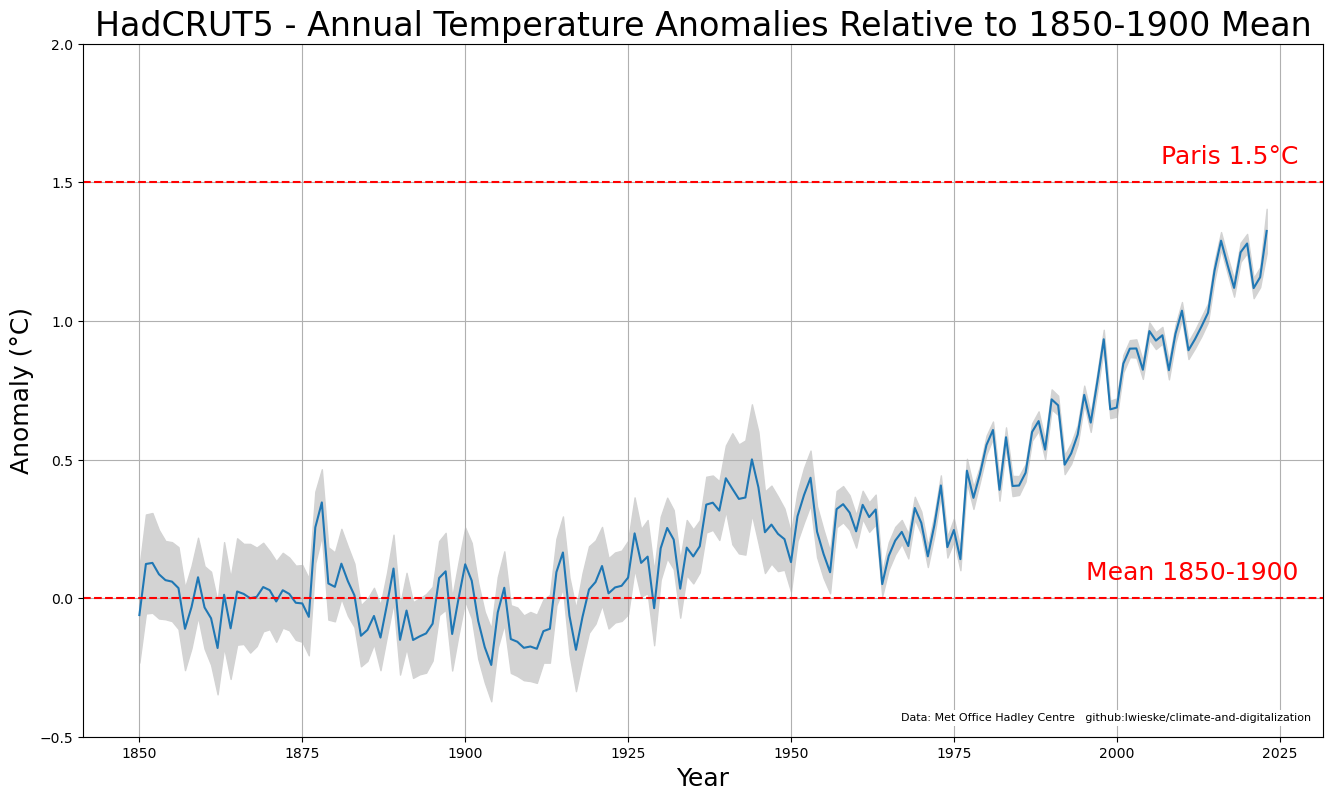

In [6]:
plt.rcParams["figure.figsize"] = (16,9)

ax = plt.gca()

plt.plot(df['time'].values, df['anomaly'].values)

ax.set_ylim([-0.5, 2.0])

plt.fill_between(df['time'].values, df['lower'].values, df['upper'].values, color="lightgray")

plt.axhline(y = 1.5, color = 'r', linestyle = 'dashed')

plt.axhline(y = 0.0, color = 'r', linestyle = 'dashed')

plt.xlabel('Year', size = 18)
plt.ylabel('Anomaly (°C)', size = 18)

plt.annotate(
    "Paris 1.5°C",
    xy=(0.98, 0.82),
    xycoords="axes fraction",
    fontsize=18,
    color='red',
    horizontalalignment="right",
    verticalalignment="bottom",
)

plt.annotate(
    "Mean 1850-1900",
    xy=(0.98, 0.22),
    xycoords="axes fraction",
    fontsize=18,
    color='red',
    horizontalalignment="right",
    verticalalignment="bottom",
)

finalize_plot(plt,
    'HadCRUT5 - Annual Temperature Anomalies Relative to 1850-1900 Mean',
    'Data: Met Office Hadley Centre   github:lwieske/climate-and-digitalization',
    'hadcrut5_annual_temperature_anomalies_relative_mean',
)

# Mauna Loa Monthly In-Situ CO2

In [7]:
maunaloa = pd.read_csv('data/weekly_in_situ_co2_mlo.csv',
    header=60,
    usecols=[0,1],
    names=['Date', 'CO2']
)

In [8]:
df = maunaloa

df = df['1960-01-01' <= df['Date']]

df = df.set_index('Date')

df.index = pd.to_datetime(df.index)

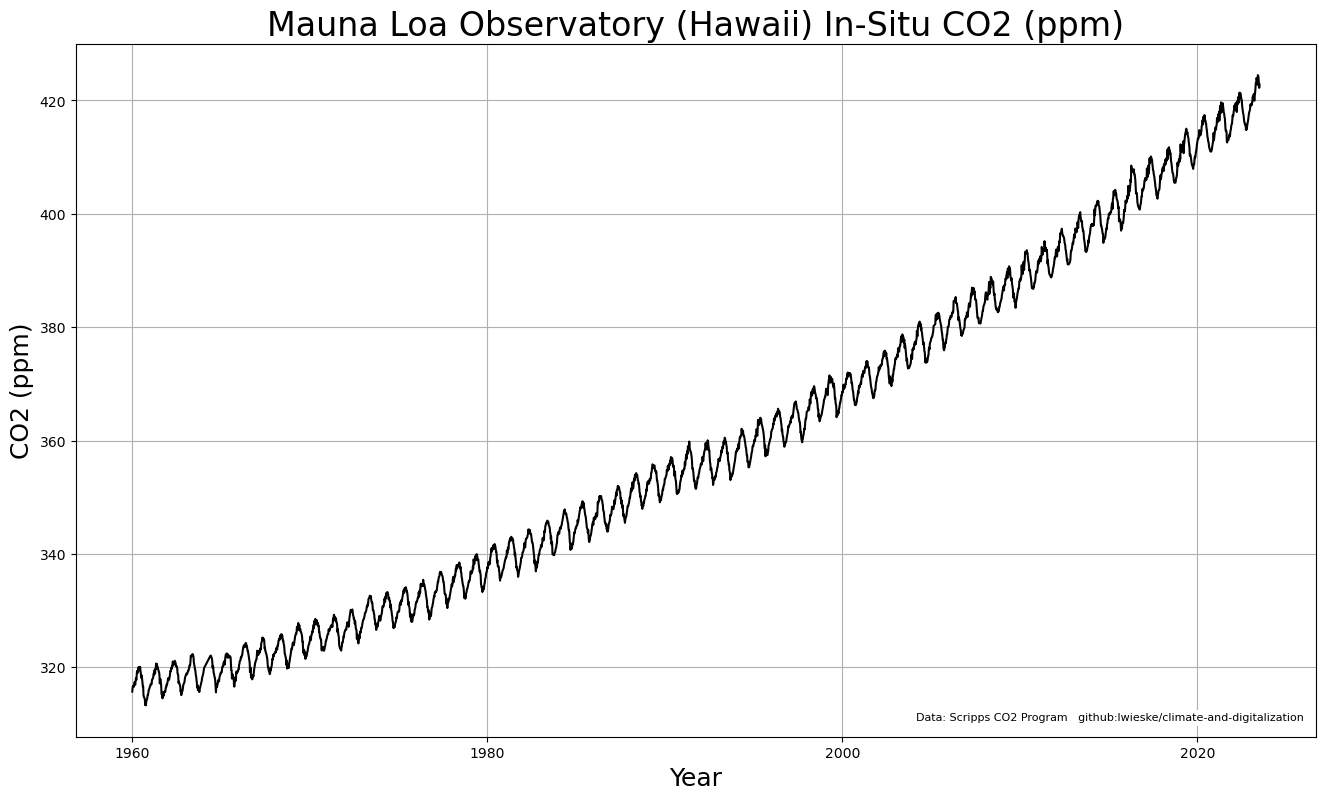

In [9]:
plt.rcParams["figure.figsize"] = (16,9)

ax = plt.gca()

ax.plot(df, color='black')

plt.xlabel('Year', size = 18)
plt.ylabel('CO2 (ppm)', size = 18)

plt.xticks(
    ticks=['1960-01-01', '1980-01-01', '2000-01-01', '2020-01-01'],
    labels=['1960', '1980', '2000', '2020'],
)

plt.title('Mauna Loa Observatory (Hawaii) In-Situ CO2 (ppm)', size = 24)

finalize_plot(plt,
    'Mauna Loa Observatory (Hawaii) In-Situ CO2 (ppm)',
    'Data: Scripps CO2 Program   github:lwieske/climate-and-digitalization',
    'mauna_loa_weekly_insite_co2',
)

# Global Digital Economy Emissions / Schneider Projections

## Global Digital Economy Emissions 2023

In [10]:
schneider_projections = ({
    'Portion':[
        'Compute',
        'Storage',
        'DC infrastructures',
        'Fixed networks',
        'Mobile networks',
        'IT devices use',
        'Network equipment use',
        'IoT devices use',
        'TVs and peripherals use',
        'Device manufacturing',
    ],
    '2023': [
         69,
         17,
        111,
         97,
         62,
         78,
         65,
         45,
        198,
        264,
    ],
    '2030': [
        125,
         41,
        106,
         90,
        155,
         54,
         87,
        110,
        146,
        287,
    ]
})

# Share of global energy-related emissions    |  2.8% |  3.0% |  3.4%

In [11]:
df = pd.DataFrame(schneider_projections)

df = df.set_index('Portion')

df = df.rename(index={
    'DC infrastructures':      'DCs',
    'Device manufacturing':    'Devices',
    'Mobile networks':         '2G-5G',
    'TVs and peripherals use': 'TVs ETAL',
})

total2023           = sum(df['2023'])
pieDict2023         = df.nlargest(3,['2023'])[['2023']].to_dict()['2023']
rest2023            = total2023 - sum(pieDict2023.values())
pieDict2023['Rest'] = total2023

total2030           = sum(df['2030'])
pieDict2030         = df.nlargest(3,['2030'])[['2030']].to_dict()['2030']
rest2030            = total2030 - sum(pieDict2030.values())
pieDict2030['Rest'] = total2030

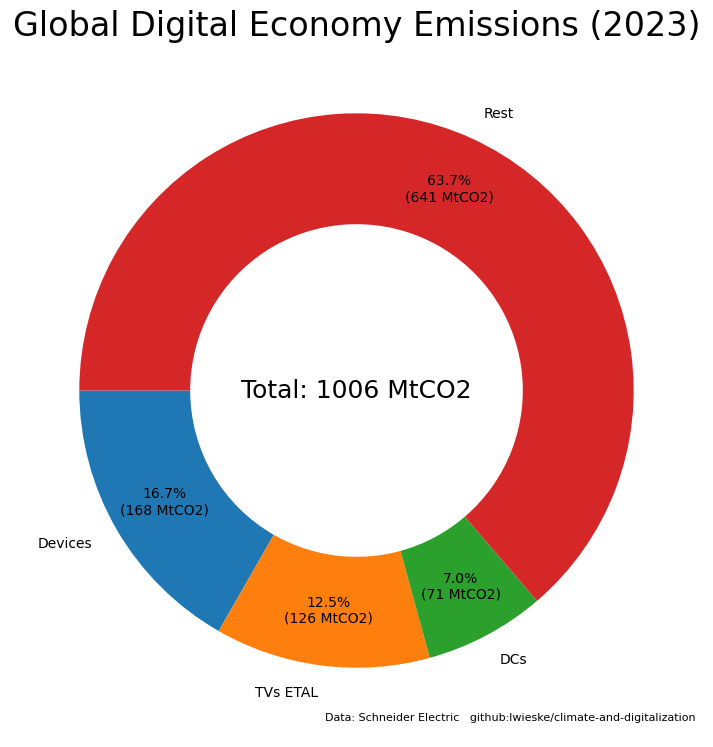

In [12]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total2023))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

plt.pie(
    pieDict2023.values(),
    labels=pieDict2023.keys(),
    autopct=lambda pct: func(pct, pieDict2023.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

plt.text(0, 0, f'Total: {total2023} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

finalize_plot(plt,
    'Global Digital Economy Emissions (2023)',
    'Data: Schneider Electric   github:lwieske/climate-and-digitalization',
    'global_schneider_digital_economy_2023',
)

## Global Digital Economy Emissions 2030

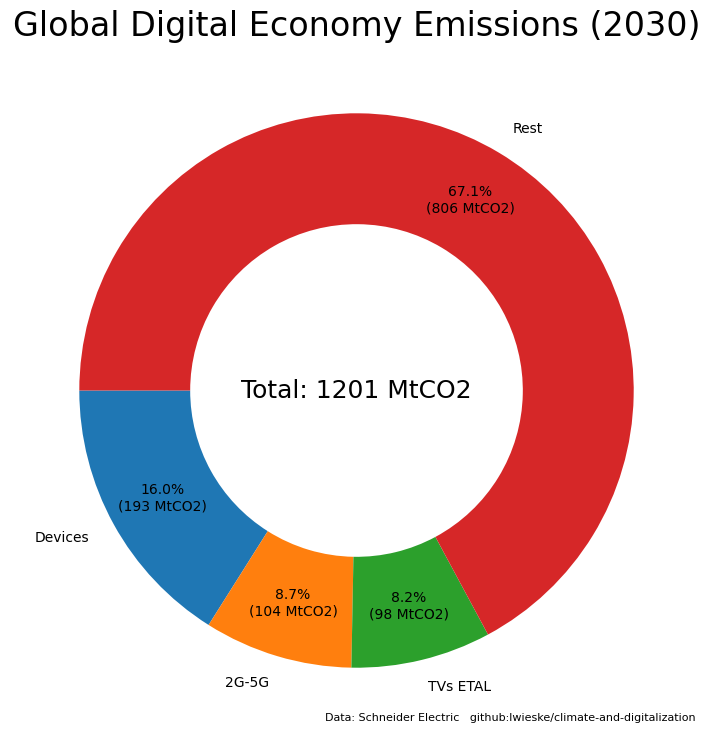

In [13]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total2030))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

plt.pie(
    pieDict2030.values(),
    labels=pieDict2030.keys(),
    autopct=lambda pct: func(pct, pieDict2030.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

plt.text(0, 0, f'Total: {total2030} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

finalize_plot(plt,
    'Global Digital Economy Emissions (2030)',
    'Data: Schneider Electric   github:lwieske/climate-and-digitalization',
    'global_schneider_digital_economy_2030',
)

plt.show()

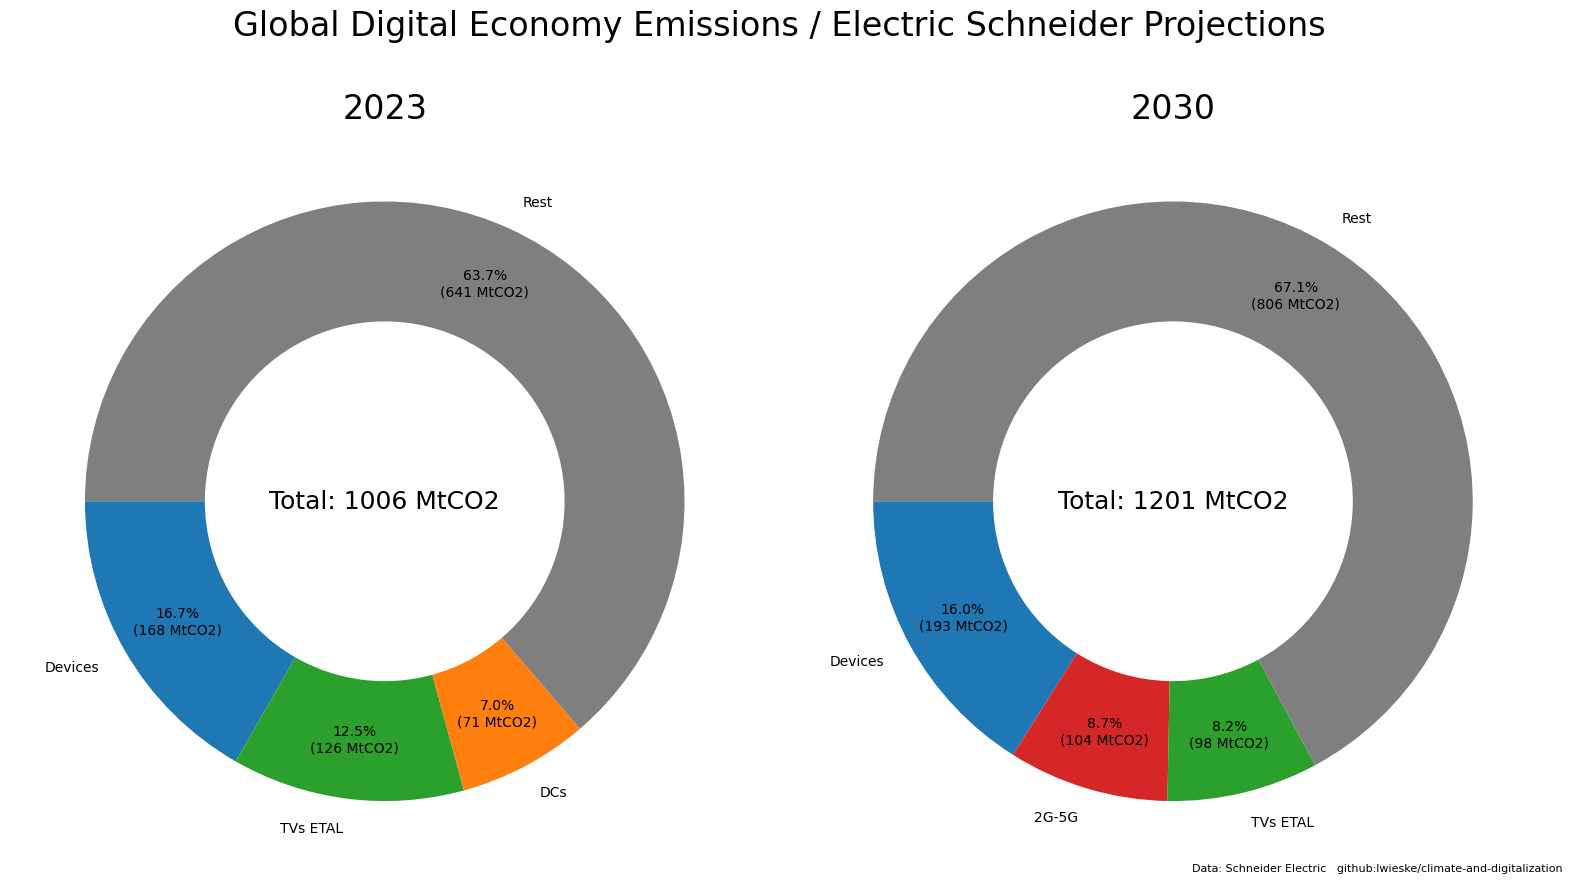

In [14]:
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Global Digital Economy Emissions / Electric Schneider Projections', size=24)

def func2023(pct, allvals):
    absolute = int(np.round(pct/100.*total2023))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

ax1.pie(
    pieDict2023.values(),
    labels=pieDict2023.keys(),
    colors=[
        mcolors.TABLEAU_COLORS['tab:blue'],
        mcolors.TABLEAU_COLORS['tab:green'],
        mcolors.TABLEAU_COLORS['tab:orange'],
        mcolors.TABLEAU_COLORS['tab:gray'],
    ],
    autopct=lambda pct: func2023(pct, pieDict2023.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

ax1.text(0, 0, f'Total: {total2023} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

ax1.set_title(f'\n2023', size=24)

def func2030(pct, allvals):
    absolute = int(np.round(pct/100.*total2030))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

ax2.pie(
    pieDict2030.values(),
    labels=pieDict2030.keys(),
    colors=[
        mcolors.TABLEAU_COLORS['tab:blue'],
        mcolors.TABLEAU_COLORS['tab:red'],
        mcolors.TABLEAU_COLORS['tab:green'],
        mcolors.TABLEAU_COLORS['tab:gray'],
    ],
    autopct=lambda pct: func2030(pct, pieDict2030.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

ax2.text(0, 0, f'Total: {total2030} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

ax2.set_title('2030', size=24)

fig.text(0.99, 0.02, 
        'Data: Schneider Electric   github:lwieske/climate-and-digitalization', 
        fontsize=8, color='black',
        ha="right", va="bottom",
        bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',)
)

plt.savefig('images/svg/global_schneider_digital_economy.svg')

plt.show()

![Global Average Temperature (°C) Relative To1850-1900](https://www.metoffice.gov.uk/binaries/content/gallery/metofficegovuk/images/research/news/2020/hadcrut5_timeseries_comparison.png)

# Annual Greenhouse Gas Index

In [15]:
aggi=pd.read_csv('data/AGGI_Table.csv', header=2, skipfooter=4, index_col=0, engine='python')

In [16]:
df = aggi

df = df[df.index >= 1990]

df = df.rename(columns={'Total.1': 'PPM', '1990 = 1':'AGGI'})

del df[df.columns[-1]]

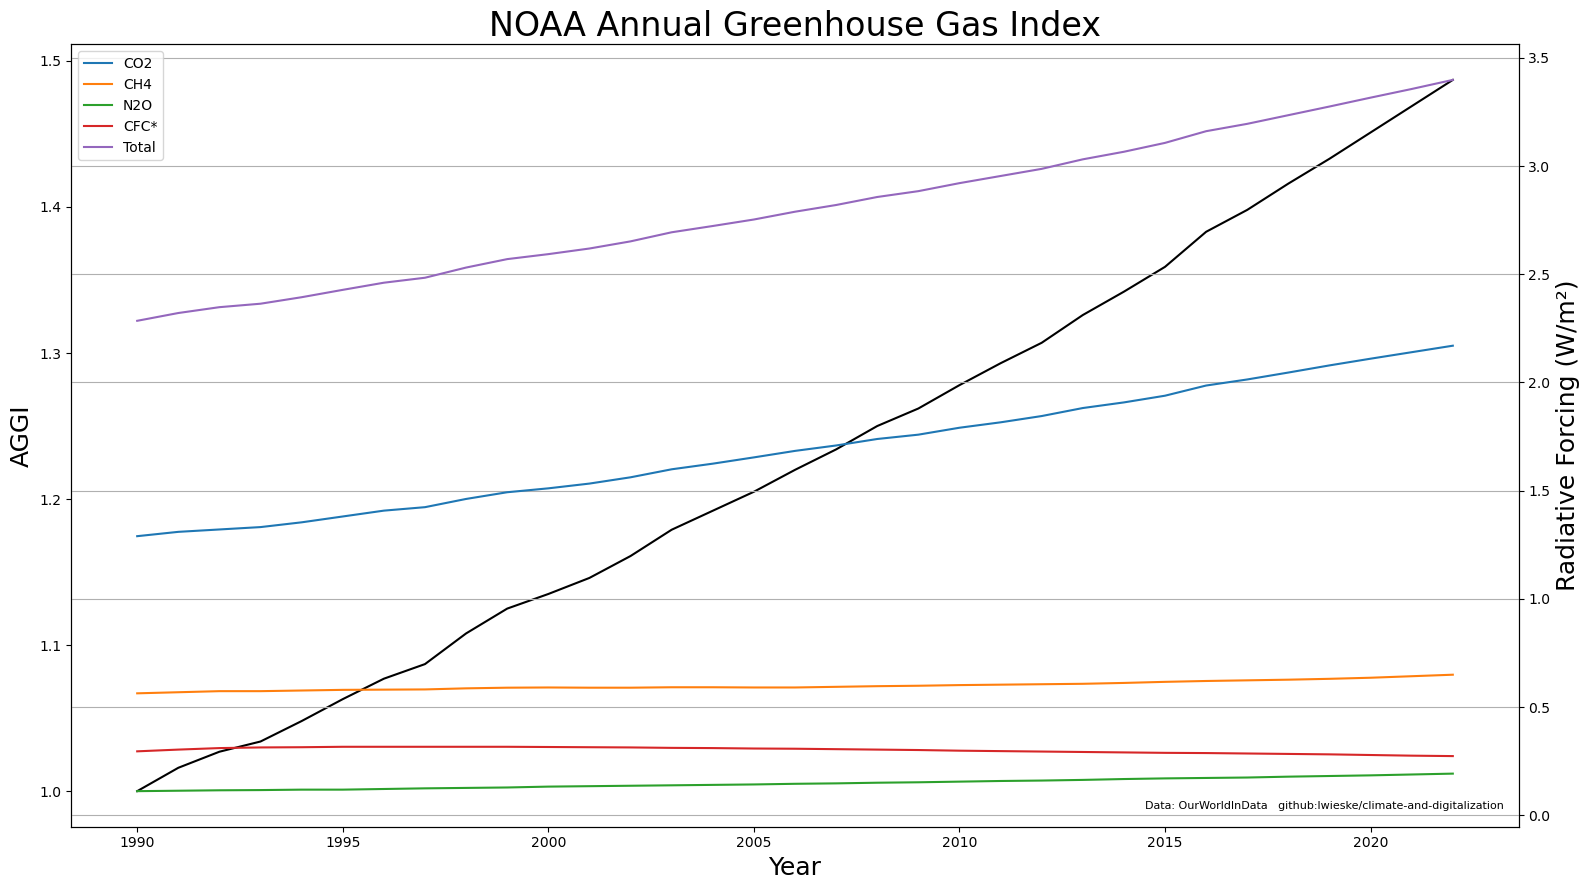

In [17]:
plt.rcParams["figure.figsize"] = (16,9)

ax1 = plt.gca()

ax1.plot(df[[ 'AGGI' ]], color='black')
ax1.set_xlabel('Year', size = 18)
ax1.set_ylabel('AGGI', size = 18)

ax2 = ax1.twinx()

ax2.plot(df[[ 'CO2' ]],   label='CO2')
ax2.plot(df[[ 'CH4' ]],   label='CH4')
ax2.plot(df[[ 'N2O' ]],   label='N2O')
ax2.plot(df[[ 'CFC*' ]],  label='CFC*')
ax2.plot(df[[ 'Total' ]], label='Total')
ax2.set_ylabel('Radiative Forcing (W/m²)', size = 18)

ax2.legend(loc='upper left')

finalize_plot(plt,
    'NOAA Annual Greenhouse Gas Index',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'noaa_annual_greenhouse_gas_index',
)

# Energy Consumption

## Annual Energy Consumption

### Global Annual Primary Energy Consumption by Region

In [18]:
raw_owid_energy_data = pd.read_csv('data/owid-energy-data.csv')

In [19]:
df = raw_owid_energy_data

df = df[df['year'] >= 2003]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('primary_energy_consumption', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                            'World'
                        ]]

df = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs)

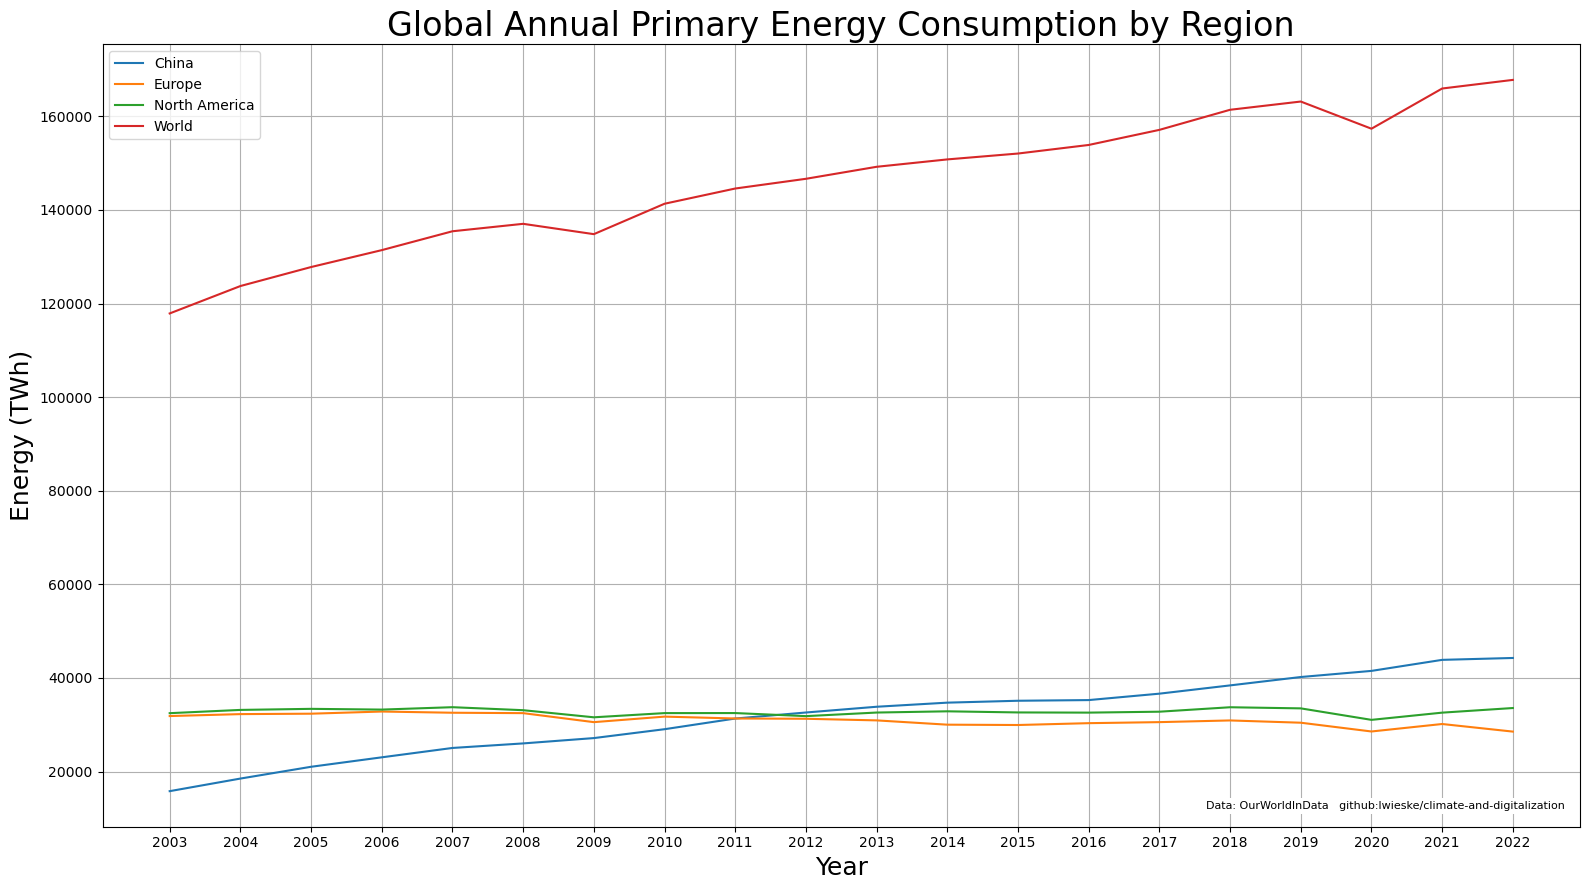

In [20]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Global Annual Primary Energy Consumption by Region',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_annual_primary_energy_consumption_by_region',
)

### Global Annual Primary Energy Consumption by Source

In [21]:
df = raw_owid_energy_data

df = df[df['country'] == 'World']
df = df[df['year'] >= 2003]

df = df.set_index(['year'])

df = df.filter(regex='consumption$',axis=1)

df = df.drop([
    'low_carbon_consumption',      # low_carbon = nuclear + renewables
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'other_renewable_consumption', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_consumption',            # fossil_fuel = coal + gas + oil
    'gas_consumption',
    'oil_consumption',
], axis=1)

df = df.rename(columns={
    'fossil_fuel_consumption': 'Fossil',
    'nuclear_consumption': 'Nuclear',
	'renewables_consumption': 'Renewables',
    'primary_energy_consumption': 'Total',
})

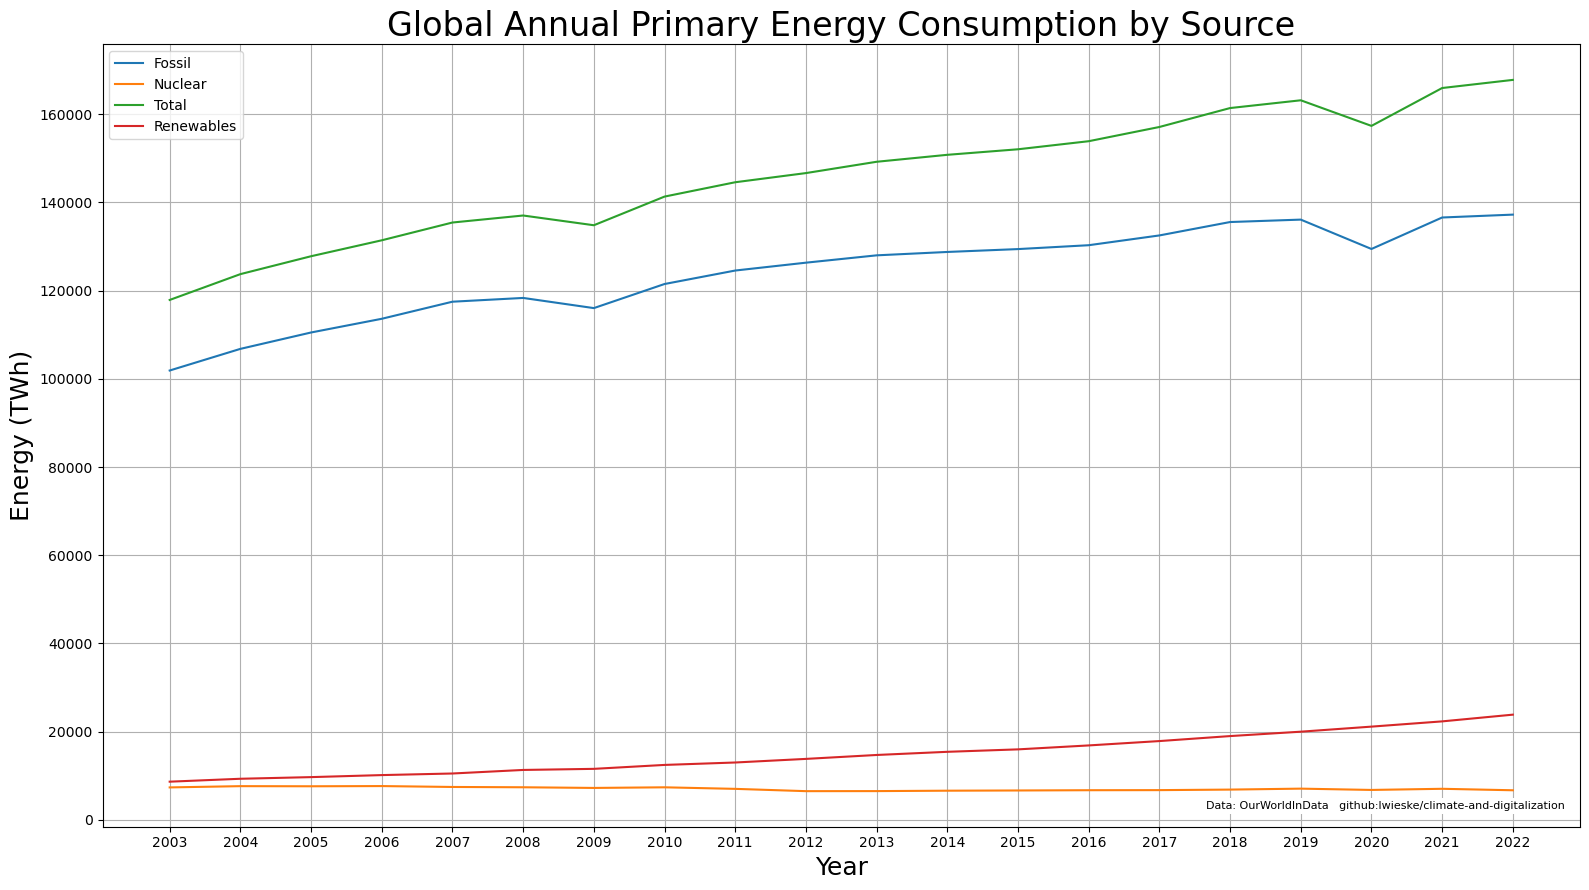

In [22]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Global Annual Primary Energy Consumption by Source',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_annual_primary_energy_consumption_by_source',
)

## Actual Energy Consumption

### Global Actual Primary Energy Consumption by Region

In [23]:
df = raw_owid_energy_data

total = df[(df['year'] == 2021) & (df['country'] == 'World')]['primary_energy_consumption'].values[0]

df = df[df['year'] == 2021]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('primary_energy_consumption', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                        ]]

pieDict = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs).T.to_dict()[2021]

pieDict['Rest'] = total - sum(pieDict.values())

In [24]:
pieDict

{'China': 43873.07,
 'Europe': 30166.586,
 'North America': 32593.902,
 'Rest': 59312.59799999998}

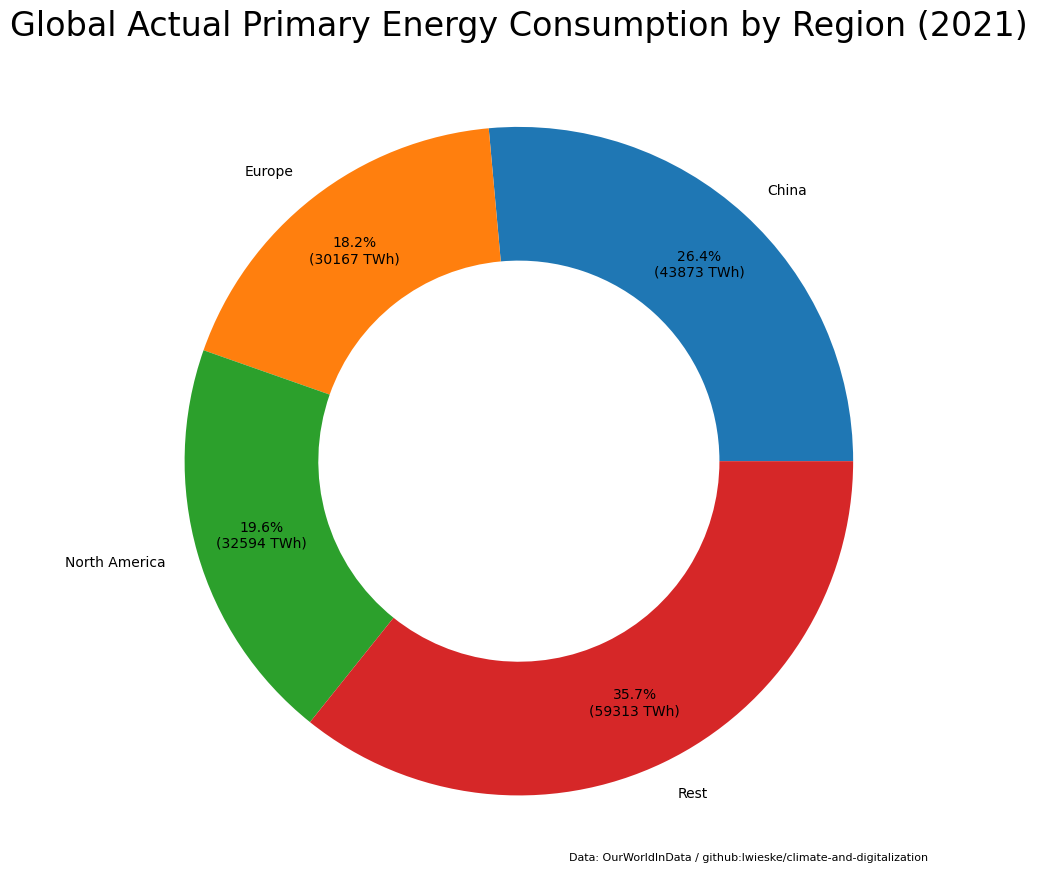

In [25]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Primary Energy Consumption by Region (2021)',
    'Data: OurWorldInData / github:lwieske/climate-and-digitalization',
    'global_actual_primary_energy_consumption_by_region',
)

### Global Actual Primary Energy Consumption by Source

In [26]:
df = raw_owid_energy_data

df = df[(df['country'] == 'World') & (df['year'] == 2022)]

df = df.set_index(['year'])

df = df.filter(regex='consumption$',axis=1)

df = df.drop([
    'low_carbon_consumption',      # low_carbon = nuclear + renewables
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'other_renewable_consumption', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_consumption',            # fossil_fuel = coal + gas + oil
    'gas_consumption',
    'oil_consumption',
    'primary_energy_consumption'   # total
], axis=1)

df = df.rename(columns={
    'fossil_fuel_consumption': 'Fossil',
    'nuclear_consumption': 'Nuclear',
	'renewables_consumption': 'Renewables',
})

pieDict = df.T.to_dict()[2022]

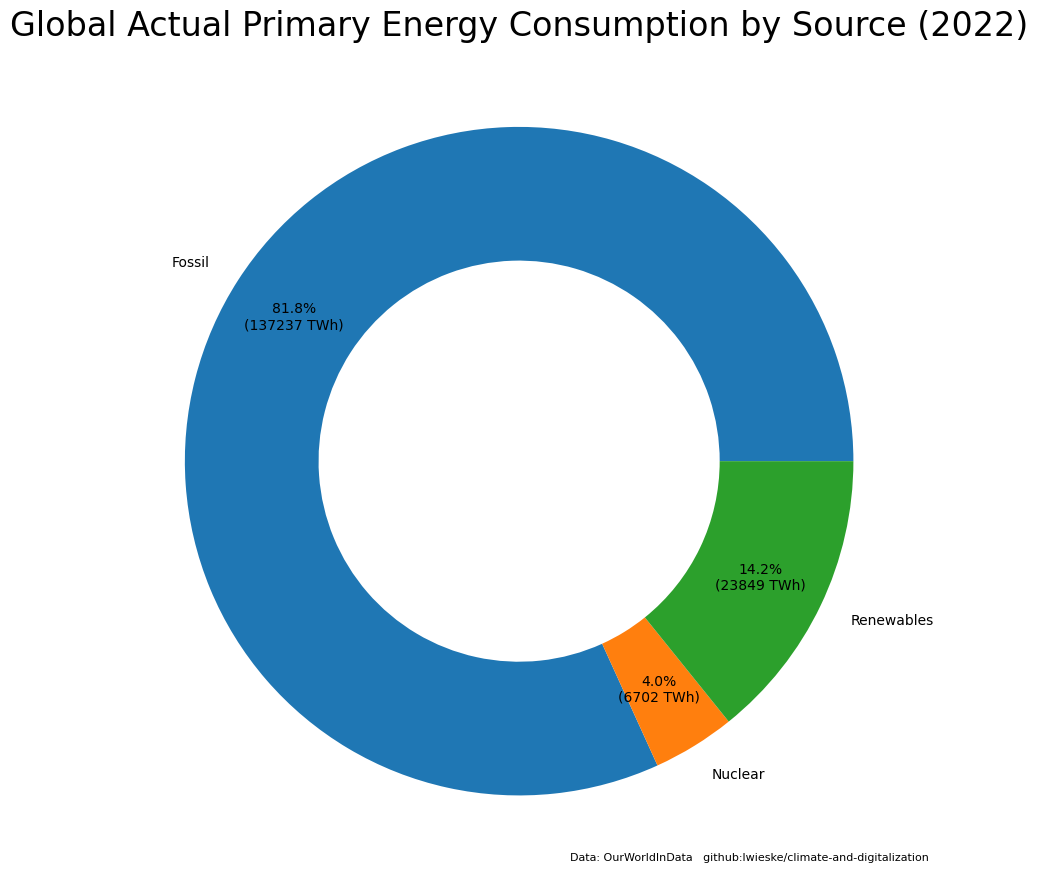

In [27]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Primary Energy Consumption by Source (2022)',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_actual_primary_energy_consumption_by_source',
)

# Electricity Generation

## Annual Electricity Generation

### Global Annual Electricity Generation by Region

In [28]:
df = raw_owid_energy_data

df = df[df['year'] >= 2003]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('electricity_generation', region) for region in [
                        'China',
                        'Europe',
                        'North America',
]]

df = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs)

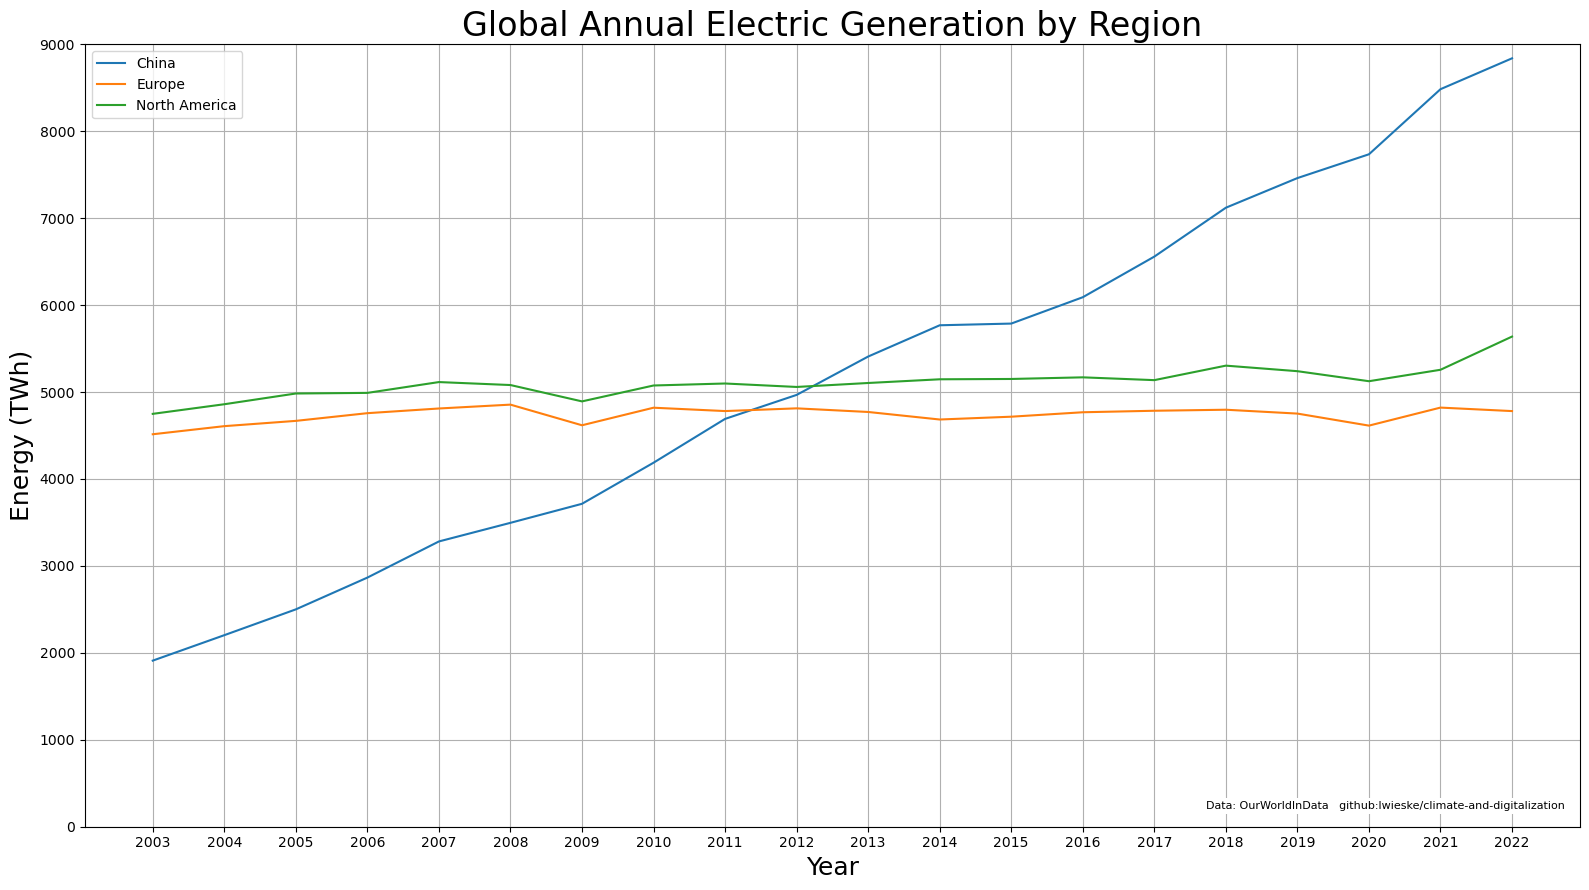

In [29]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.ylim(0, 9000)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

plt.title('Global Annual Electric Generation by Region', size = 24)

finalize_plot(plt,
    'Global Annual Electric Generation by Region',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_annual_electricity_generation_by_region',
)

### Global Annual Electricity Generation by Source

In [30]:
df = raw_owid_energy_data

df = df[df['country'] == 'World']
df = df[df['year'] >= 2003]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',      # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',            # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'electricity_demand',          # ... other ...
    'electricity_share_energy',  
    'other_renewable_exc_biofuel_electricity',
    'per_capita_electricity',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
    'electricity_generation': 'Total',
})

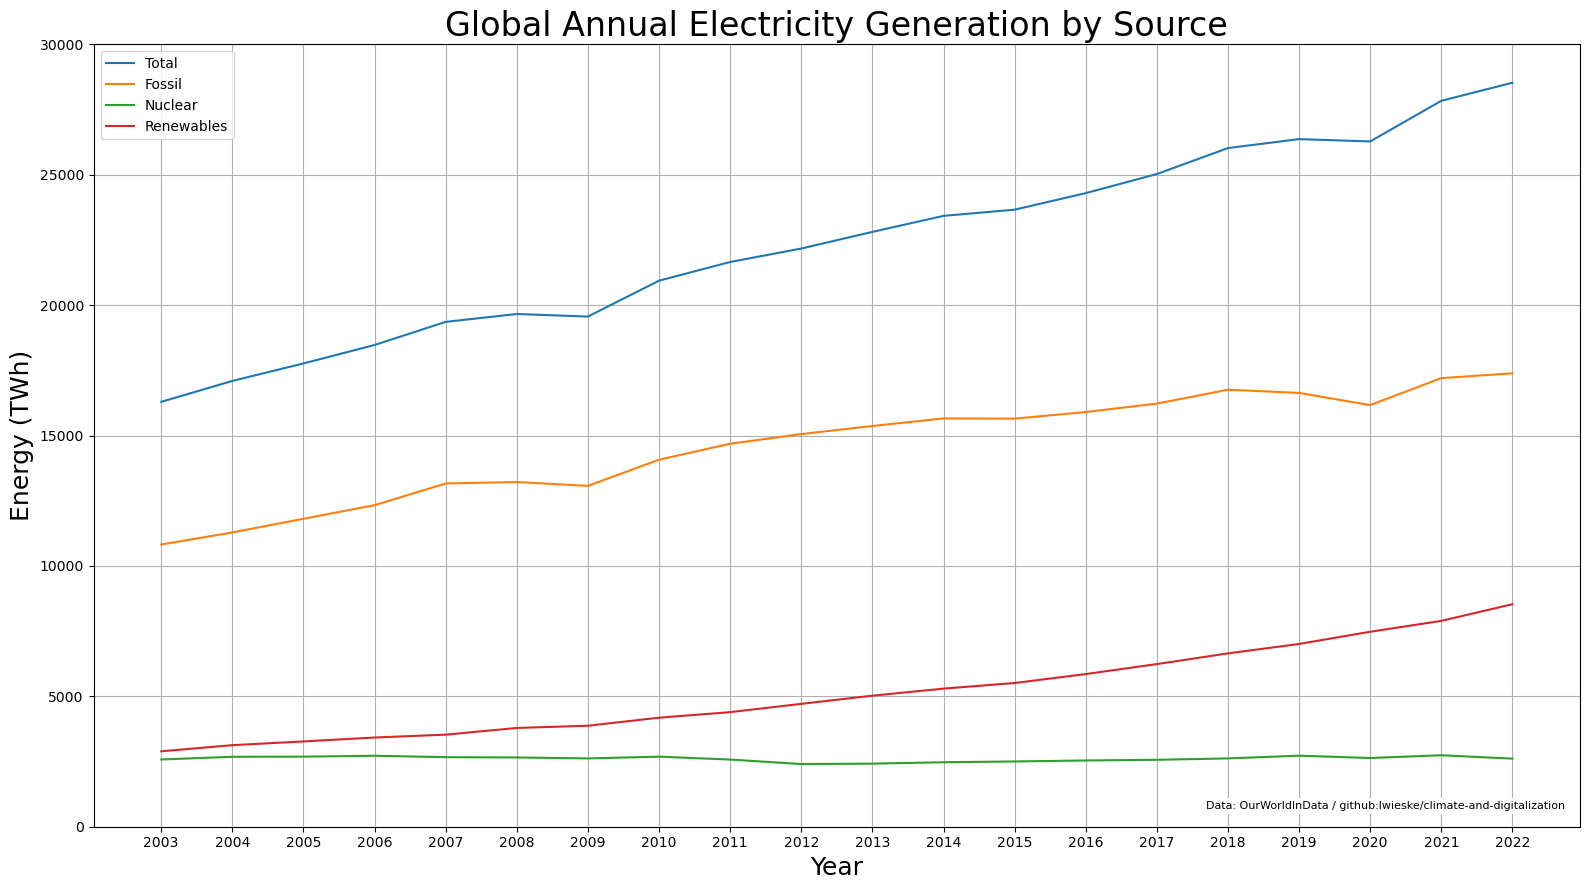

In [31]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year", size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.ylim(0, 30000)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Global Annual Electricity Generation by Source',
    'Data: OurWorldInData / github:lwieske/climate-and-digitalization',
    'global_annual_electricity_generation_by_source',
)

## Actual Electricity Generation

### Actual Electricity Generation by Region

In [32]:
df = raw_owid_energy_data

total = df[(df['year'] == 2021) & (df['country'] == 'World')]['electricity_generation'].values[0]

df = df[df['year'] == 2021]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('electricity_generation', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                        ]]

pieDict = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs).T.to_dict()[2021]

pieDict['Rest'] = total - sum(pieDict.values())

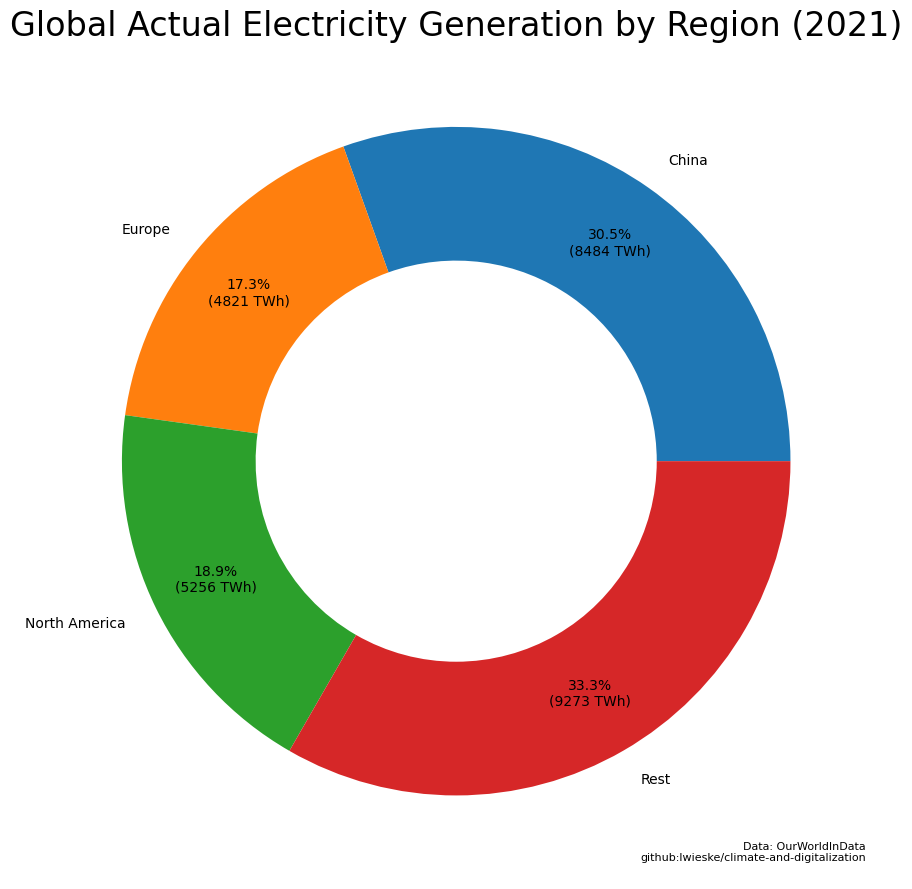

In [33]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Electricity Generation by Region (2021)',
    'Data: OurWorldInData\ngithub:lwieske/climate-and-digitalization',
    'global_actual_electricity_generation_by_region',
)

### Actual Electricity Generation by Source

In [34]:
df = raw_owid_energy_data

df = df[(df['country'] == 'World') & (df['year'] == 2022)]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',                  # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity',
    'other_renewable_exc_biofuel_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',                        # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'per_capita_electricity',
    'electricity_demand',
    'electricity_generation',                   # total
    'electricity_share_energy',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
})

pieDict = df.T.to_dict()[2022]

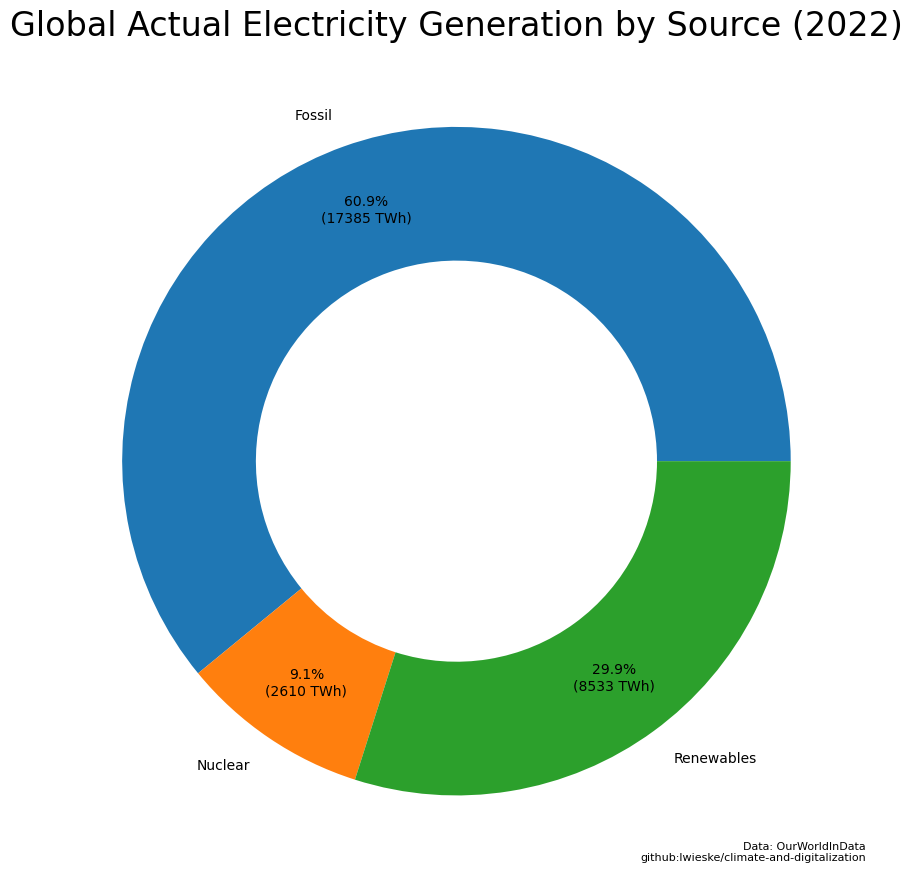

In [35]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Electricity Generation by Source (2022)',
    'Data: OurWorldInData\ngithub:lwieske/climate-and-digitalization',
    'global_actual_electricity_generation_by_source',
)

![US energy consumption by source and sector, 2022](https://www.eia.gov/totalenergy/data/monthly/pdf/flow/css_2022.png)

# CO2 Emissions and GDP per Capita

[CO2 Emissions and GDP per Capita](https://ourworldindata.org/grapher/co2-emissions-and-gdp-per-capita)

![Germany - CO2 Emissions and GDP per Capita](images/co2-emissions-and-gdp-per-capita.png)

In [36]:
raw_worldbank_gdp_pcap_data = pd.read_excel('data/NY.GDP.PCAP.KD.xlsx', sheet_name='Data', header=3)

In [37]:
df = raw_worldbank_gdp_pcap_data

df = df[df['Country Name'] == 'Germany']

df = df.drop([
    'Country Name',
    'Country Code',
    'Indicator Name',
    'Indicator Code'
], axis=1)

df = df.T

df.index = df.index.astype('int')

df = df[(1990 <= df.index) & (df.index <= 2021)]

df.index.name = 'year'

df = df.rename(columns={ df.columns[0]: "GDP PCAP" })

df1 = df

In [38]:
raw_owid_co2_data = pd.read_csv('data/owid-co2-data.csv')

In [39]:
df = raw_owid_co2_data

df = df[df['country'] == 'Germany']

df = df.set_index('year')

df = df[(1990 <= df.index) & (df.index <= 2021)]

df = df[['co2_per_capita']]

df = df.rename(columns={ df.columns[0]: "CO2 PCAP" })

df2 = df

In [40]:
gdp_pcap = df1
co2_pcap = df2

df = pd.merge(df1, df2, left_index=True, right_index=True)

df['GDP PCAP'] /= df.loc[1990]['GDP PCAP'] * 0.01
df['CO2 PCAP'] /= df.loc[1990]['CO2 PCAP'] * 0.01

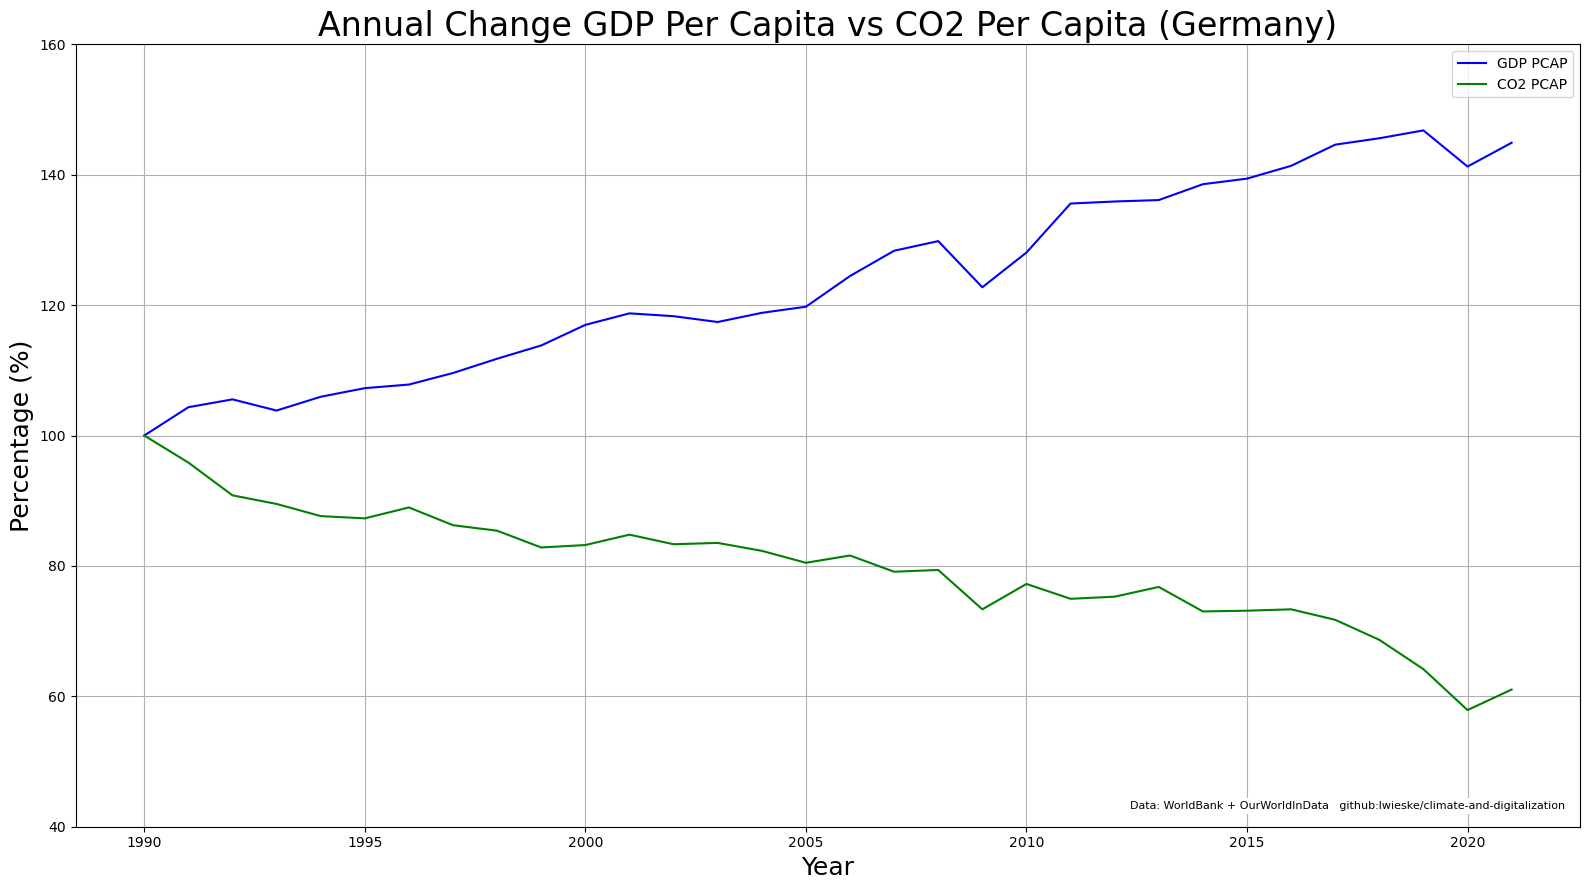

In [41]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(color=['blue', 'green'])

plt.ylim(40, 160)

plt.xlabel("Year",  size = 18)
plt.ylabel("Percentage (%)", size = 18)

finalize_plot(plt,
    'Annual Change GDP Per Capita vs CO2 Per Capita (Germany)',
    'Data: WorldBank + OurWorldInData   github:lwieske/climate-and-digitalization',
    'germany_annual_change_gdp_vs_co2_per_capita',
)

# Coupled Model Intercomparison Project (CMIP)

## CMIP6 - Ensemble Mean Surface Air Temperature

Adapted from [Copernicus Training C3S](https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cmip6.ipynb)

In [42]:
# variables EXPERIMENTS MODELS

EXPERIMENTS = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

MODELS      = ['ipsl_cm6a_lr', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

CMIP6DATA = './data/cmip6/'

URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '123456:11111111-2222-3333-4444-555555555555'
KEY = '251580:737d33c2-8ccc-47f7-83f5-e0ecd396c785'

In [43]:
# download and unzip models and experiments from Copernicus Climate Data Store

client = cdsapi.Client(url=URL, key=KEY)

for m in MODELS:
    file = f'{CMIP6DATA}cmip6_monthly_1850-2014_historical_{m}.zip'
    if not os.path.isfile(file):
        client.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': 'historical',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{m}',
                'date': '1850-01-01/2014-12-31',
            },
            file
        )

for e in EXPERIMENTS[1:]:
    for m in MODELS:
        file = f'{CMIP6DATA}cmip6_monthly_2015-2100_{e}_{m}.zip'
        if not os.path.isfile(file):
            client.retrieve(
                'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'monthly',
                    'experiment': f'{e}',
                    'level': 'single_levels',
                    'variable': 'near_surface_air_temperature',
                    'model': f'{m}',
                    'date': '2015-01-01/2100-12-31',
                },
                file
            )

for z in glob.glob(f'{CMIP6DATA}*.zip'):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(f'{CMIP6DATA}')

In [44]:
# spatial and temporal aggregation 

def spatial_aggregation(tas):
    weights = np.cos(np.deg2rad(tas.lat))
    weights.name = "weights"
    tas_weighted = tas.weighted(weights)
    return tas_weighted.mean(['lat', 'lon'])

def temporal_aggregation(tas_spat_aggr, model_id, experiment_id):
    tas_temp_aggr = tas_spat_aggr.groupby('time.year').mean()
    tas_temp_aggr = tas_temp_aggr - 273.15
# convert_temperature(np.array([-40, 40]), 'Celsius', 'Kelvin') scipy.constants.K2C¶
    tas_temp_aggr = tas_temp_aggr.assign_coords(model=model_id)
    tas_temp_aggr = tas_temp_aggr.expand_dims('model')
    tas_temp_aggr = tas_temp_aggr.assign_coords(experiment=experiment_id)
    tas_temp_aggr = tas_temp_aggr.expand_dims('experiment')
    return tas_temp_aggr

list(map(lambda x: os.remove(x), glob.glob(f'{CMIP6DATA}cmip6_aggr_*.nc')))

for nc in list(map(lambda x: os.path.basename(x), glob.glob(f'{CMIP6DATA}tas*.nc'))):

    dataset = xr.open_dataset(f'{CMIP6DATA}{nc}')

    experiment_id = dataset.attrs['experiment_id']
    model_id      = dataset.attrs['source_id']

    tas_spat_aggr = spatial_aggregation(dataset['tas'])

    tas_temp_aggr = temporal_aggregation(tas_spat_aggr, model_id, experiment_id)

    netcdf_file = f'cmip6_aggr_{experiment_id}_{model_id}_{str(tas_temp_aggr.year[0].values)}.nc'

    tas_temp_aggr.to_netcdf(path=f'{CMIP6DATA}{netcdf_file}')

In [45]:
# statistical quantile derivations 

data = xr.open_mfdataset(f'{CMIP6DATA}cmip6_aggr_*.nc').load()['tas']

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    data_90_quantile = data.quantile(0.9, dim='model')
    data_10_quantile = data.quantile(0.1, dim='model')
    data_50_quantile = data.quantile(0.5, dim='model')

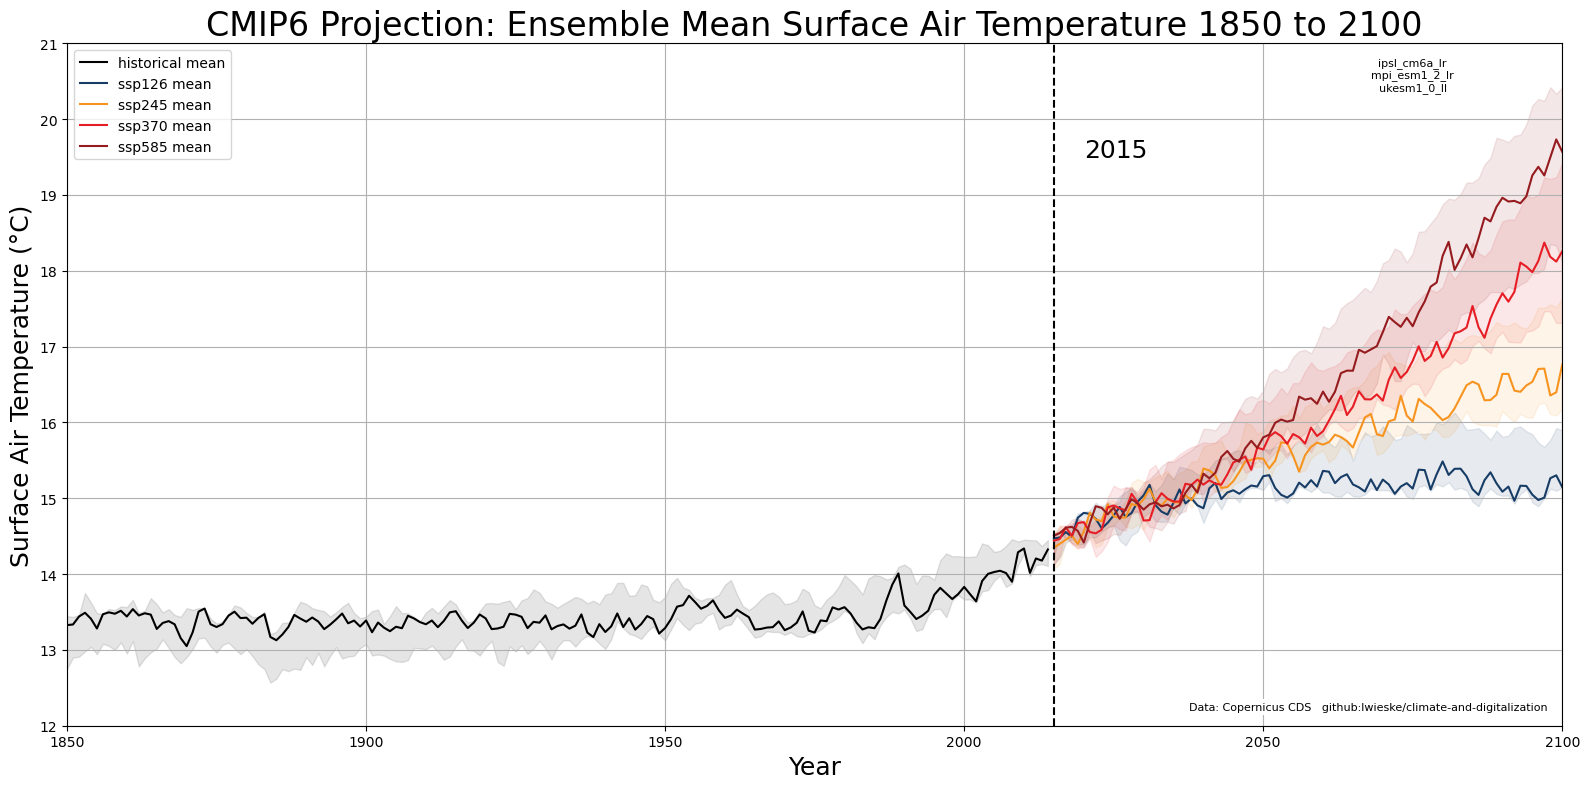

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black', '#173C66', '#F79420', '#E71D25', '#951B1E']

# SSP1-1.9: #00ADCF (RGB: 0, 173, 207)
# SSP1-2.6: #173C66 (RGB: 23, 60, 102)
# SSP2-4.5: #F79420 (RGB: 247, 148, 32)
# SSP3-7.0: #E71D25 (RGB: 231, 29, 37)
# SSP5-8.5: #951B1E (RGB: 149, 27, 30)
# Gomis & Pidcock (2022): IPCC Visual Style Guide ...

for i in np.arange(len(EXPERIMENTS)):
    ax.plot(
        data_50_quantile.year,
        data_50_quantile[i,:],
        color=f'{colours[i]}',
        label=f'{data_50_quantile.experiment[i].values} mean'
    )
    ax.fill_between(
        data_50_quantile.year,
        data_90_quantile[i,:],
        data_10_quantile[i,:],
        alpha=0.1,
        color=f'{colours[i]}',
        label='_nolegend_'
    )

ax.set_xlim(1850,2100)
ax.set_ylim(12,21)

ax.set_xlabel('Year', size = 18)
ax.set_ylabel('Surface Air Temperature (°C)', size = 18)

ax.axvline(2015, ymin=0, ymax=1, color='black', linestyle='--')
ax.text(2015+5, 19.5, '2015', size = 18)

ax.annotate(
    '\n'.join(MODELS),
    xy=(0.90, 0.98), xycoords='axes fraction',
    fontsize=8, color='black',
    ha='center', va='top',
    bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',),
)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, loc='upper left')

finalize_plot(plt,
    'CMIP6 Projection: Ensemble Mean Surface Air Temperature 1850 to 2100',
    'Data: Copernicus CDS   github:lwieske/climate-and-digitalization',
    'cmip6_ensemble_mean_surface_air_temperature',
)

# GHG Emissions aggregated By Sector

![Global GHG Emissions By Sector](https://ourworldindata.org/uploads/2020/09/Emissions-by-sector-–-pie-charts.png)